In [1]:
!pip install pandas numpy scipy kadlu kaleido==0.2.1 matplotlib pyarrow pooch seaborn plotly xarray ipywidgets cfgrib cartopy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 11.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 15.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 15.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 15.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 14.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 14.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 11.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [2]:
import kadlu
#from kadlu.geospatial.interpolation import Interpolator2D

from datetime import datetime
import matplotlib.pyplot as plt

kadlu.storage_cfg(setdir='./kadlu_data/')

generated new fontManager


/home/jovyan/work/notebook/kadlu_data/

In [3]:
# load some data to interpolate
bathy, lat, lon = kadlu.load(
        var='bathymetry', source='gebco',
        south=43, west=-63, 
        north=58, east=-59
    )


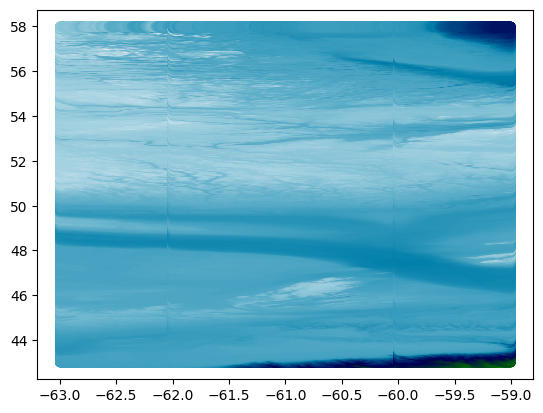

In [4]:
# quick overview of bathymetric data
fig = plt.scatter(lon, lat, c=bathy, cmap=plt.cm.ocean_r)

In [5]:
bathy[-100], lon[-100],lat[-100]

(1375.0, -59.41458333333334, 57.99791666666667)

In [6]:
#kadlu.era5_cfg(key="TOKEN_HERE", url="URL_HERE")

In [7]:
import cdsapi

client = cdsapi.Client()

dataset = 'reanalysis-era5-pressure-levels'
request = {
  'product_type': ['reanalysis'],
  'variable': ['geopotential'],
  'year': ['2024'],
  'month': ['03'],
  'day': ['01'],
  'time': ['13:00'],
  'pressure_level': ['1000'],
  'data_format': 'grib',
}
target = 'download.grib'

client.retrieve(dataset, request, target)

2025-09-18 16:24:20,655 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-18 16:24:20,657 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-18 16:24:21,360 INFO Request ID is 4f40ded5-4262-459f-bfb3-a9218f31f890
Request ID is 4f40ded5-4262-459f-bfb3-a9218f31f890
2025-09-18 16:24:21,593 INFO status has been updated to accepted
status has been updated to accepted
2025-09-18 16:24:30,812 INFO status has been updated to running
status has been updated to running
2025-09-18 16:24:36,092 INFO status h

79e8588ed2d6bf970f3f56839d004865.grib:   0%|          | 0.00/1.98M [00:00<?, ?B/s]

'download.grib'

In [8]:
import xarray as xr; 
ds = xr.open_dataset('download.grib', engine='cfgrib')

Ignoring index file 'download.grib.5b7b6.idx' older than GRIB file
/opt/conda/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [9]:
print(ds)

<xarray.Dataset> Size: 4MB
Dimensions:        (latitude: 721, longitude: 1440)
Coordinates:
    number         int64 8B ...
    time           datetime64[ns] 8B ...
    step           timedelta64[ns] 8B ...
    isobaricInhPa  float64 8B ...
  * latitude       (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    valid_time     datetime64[ns] 8B ...
Data variables:
    z              (latitude, longitude) float32 4MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-18T16:24 GRIB to CDM+CF via cfgrib-0.9.1...


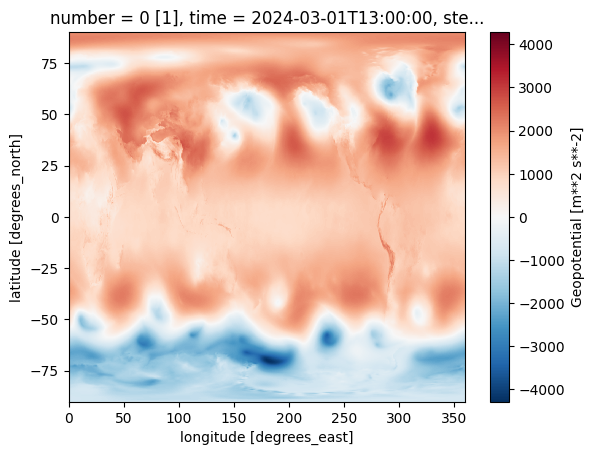

In [10]:
ds['z'].plot()
#KeyError: "No variable named 'geopotential'. Variables on the dataset include ['number', 'time', 'step', 'isobaricInhPa', 'latitude', 'longitude', 'valid_time', 'z']"

/opt/conda/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


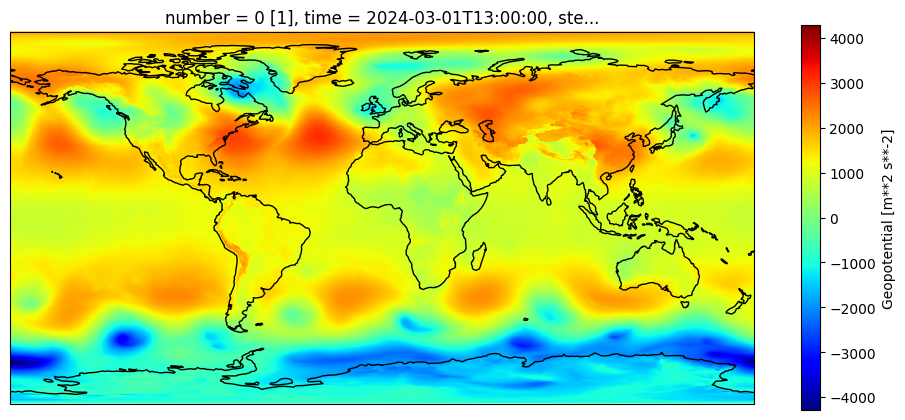

In [11]:
import cartopy.crs as ccrs
fig = plt.figure(figsize=[12,5])

# 111 means 1 row, 1 col and index 1
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))

ds['z'].plot(ax=ax, cmap='jet',
                   transform=ccrs.PlateCarree())
ax.coastlines()

plt.show()

In [12]:
import numpy as np
from datetime import datetime

from kadlu import plot_util
#from kadlu.plot_util import plot2D
from kadlu import source_map, gebco, era5, hycom, wwiii

# enable plots embedded in jupyter notebook:
%matplotlib inline

In [17]:
# figure boundaries to pass as arguments to the plot function
kwargs = dict(
        south=43.8, west=-63, 
        north=47.5, east=-59,
        bottom=0, top=0,
        start=datetime(2018, 12, 12), end=datetime(2018, 12, 13)
)
#kwargs = dict(
#        south=44, west=-63, 
#        north=56, east=-59,
#        bottom=0, top=0,
#        start=datetime(2018, 12, 12), end=datetime(2018, 12, 13)
#)

In [18]:
import os
import logging
from datetime import datetime, timedelta
from multiprocessing import Process, Queue

import numpy as np
import imageio
import matplotlib
#matplotlib.use('TkAgg')
#matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import cartopy
#import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata

from kadlu.geospatial.data_sources.source_map import load_map
from kadlu.geospatial.data_sources.data_util import fmt_coords
from kadlu.geospatial.data_sources.data_util import storage_cfg

In [19]:
config = dict(
        bgcontour   = lambda v: np.linspace(min(v)-.1, max(v)+.1, 3),
        bathymetry=dict(
            cm      = plt.cm.bone.reversed(),
            alpha   = 0.9,
            levels  = lambda v, n=12: np.linspace(1, max(v)-1, n),
            norm    = lambda v: matplotlib.colors.Normalize(vmin=0, vmax=max(v)-1),
            title   = 'bathymetry (metres)'),
        temp=dict(
            cm      = plt.cm.coolwarm, 
            alpha   = 0.8,
            levels  = lambda v, n=12: np.linspace(min(v)-.1, max(v)+.1, n),
            norm    = lambda v=None: matplotlib.colors.Normalize(vmin=-5, vmax=20),
            title   = 'temperature (celsius)'),
        salinity=dict(
            cm      = plt.cm.viridis,
            alpha   = 0.7,
            levels  = lambda v, n=12: np.linspace(min(v)+.1, max(v), n),
            norm    = lambda v=None: matplotlib.colors.Normalize(vmin=20, vmax=40),
            title   = 'salinity (g/kg salt in water)'),
        waveheight=dict(
            cm      = plt.cm.BuPu,
            alpha   = 0.85,
            levels  = lambda v, n=12: np.linspace(min(v)+.1, max(v), n),
            norm    = lambda v=None: matplotlib.colors.Normalize(vmin=0, vmax=15),
            title   = 'wave height (metres)'),
        wavedirection=dict(
            cm      = plt.cm.BuPu,
            alpha   = 0.85,
            levels  = lambda v, n=12: np.linspace(min(v)+.1, max(v), n),
            norm    = lambda v=None: matplotlib.colors.Normalize(vmin=0, vmax=15),
            title   = 'wave direction (direction)')
    )

def plot2D(var, source, plot_wind=False, save=False, **kwargs): 
    """
    
        import kadlu
        var = 'bathymetry'
        source = 'gebco'
        plot_wind, save = False, False
        kwargs = kadlu.defaults
        kadlu.plot2D(var, source, **kwargs)

    """
    var = var.lower()
    source = source.lower()

    if f'{var}_{source}' not in load_map.keys():
        raise KeyError(f'could not find source for variable. valid vars and '
                       f'sources: {[k.split("_") for k in load_map.keys()]}')

    if 'start' not in kwargs.keys():
        kwargs['start'], kwargs['end'] = datetime.now(), datetime.now()

    data = np.array(load_map[f'{var}_{source}'](**kwargs))
    #val, lat, lon = data[:3].astype(float)
    val, lat, lon = data[:3].astype(float)
    
    # project data onto coordinate space
    extent = ccrs.Mercator().transform_points(
            ccrs.Geodetic(),
            np.array([kwargs['west'], kwargs['east']]), 
            np.array([kwargs['south'], kwargs['north']])
        )[:,:-1]
    projected_lonlat = ccrs.Mercator().transform_points(
            ccrs.Geodetic(),
            lon,
            lat
        )
    plon = projected_lonlat[:,0]
    plat = projected_lonlat[:,1]
    num_lats = 1000
    num_lons = 1000
    lons = np.linspace(start=min(plon), stop=max(plon), num=num_lons)
    lats = np.linspace(start=min(plat), stop=max(plat), num=num_lats)
    data = griddata(points=(plon, plat), values=val, xi=(lons[None,:],lats[:,None]), method='linear')
    coast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m')
    fg = (.92, .92, .92, 1)
    fname = f'{var}_{kwargs["start"].date().isoformat()}.png'
    fig = plt.figure()

    ax = fig.add_subplot(1, 1, 1, 
            title=config[var]['title']+f'\n{kwargs["start"].date().isoformat()}',
            projection=ccrs.Mercator(), 
            facecolor=config[var]['cm'](256), 
            frameon=True
        )
    ax.contourf(lons, lats, data,
                transform=ccrs.Mercator(),
                levels=config[var]['levels'](val),
                cmap=config[var]['cm'], 
                alpha=config[var]['alpha'],
                zorder=8
            )
    ax.contour(lons, lats, data,
                transform=ccrs.Mercator(),
                levels=config[var]['levels'](val),
                cmap=config[var]['cm'],
                alpha=1,
                linewidths=2,
                zorder=9
            )

    if plot_wind is not False:
        if plot_wind.lower() == 'era5': 
            #windfcnU, windfcnV = (Era5().load_wind_u, Era5().load_wind_v)
            windfcnU, windfcnV = load_map['wind_u_era5'], load_map['wind_v_era5']
        elif plot_wind.lower() == 'wwiii': 
            #windfcnU, windfcnV = (Wwiii().load_wind_u, Wwiii().load_wind_v)
            windfcnU, windfcnV = load_map['wind_u_wwiii'], load_map['wind_v_wwiii']
        else: 
            raise ValueError('invalid wind source. must be \'era5\' or \'wwiii\'')

        uval, ulat, ulon, utime = windfcnU(**kwargs)
        vval, vlat, vlon, vtime = windfcnV(**kwargs)
        assert(len(vval) == len(uval))  # this can be fixed with an SQL JOIN in load module
        if len(np.unique(ulat)) == 1 or len(np.unique(ulon)) == 1:
            raise RuntimeError(f'Not enough datapoints to plot windspeeds in region {fmt_coords(kwargs)}')

        ax.quiver(ulon, ulat, uval, vval, transform=ccrs.PlateCarree(), 
                regrid_shape=20, zorder=10)

    ax.add_feature(coast, facecolor=fg, edgecolor=(0,0,0,1), zorder=11)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--',
            zorder=12)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER

    # this appears to be a known bug
    # https://github.com/SciTools/cartopy/issues/1332
    for tick in ax.get_xticklabels(): 
        tick.set_rotation(45)

    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
    ax.tick_params(axis='x', rotation=45)
    vnorm = val if var == 'bathy' or var == 'bathymetry' else None
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=config[var]['norm'](vnorm),
                cmap=config[var]['cm']), ax=ax)

    if save is not False:
        if not os.path.isdir(f'{storage_cfg()}figures'): 
            os.mkdir(f'{storage_cfg()}figures')
        logging.info(f'saving figure to {storage_cfg()}figures/{fname if save is True else save}')
        plt.savefig(f'{storage_cfg()}figures/{fname if save is True else save}', 
                bbox_inches='tight', dpi=200, figsize=(12,8), optimize=True)
        plt.close()
    else: 
        plt.show()

    return

loading data from The GEBCO_2021 Grid - a continuous terrain model for oceans and land at 15 arc-second intervals
GEBCO bathymetry: logged 0 values in region 42.00°N,44.00°N;64.00°W62.00°W
loading data from The GEBCO_2021 Grid - a continuous terrain model for oceans and land at 15 arc-second intervals
GEBCO bathymetry: logged 0 values in region 44.00°N,46.00°N;64.00°W62.00°W
loading data from The GEBCO_2021 Grid - a continuous terrain model for oceans and land at 15 arc-second intervals
GEBCO bathymetry: logged 0 values in region 46.00°N,48.00°N;64.00°W62.00°W
loading data from The GEBCO_2021 Grid - a continuous terrain model for oceans and land at 15 arc-second intervals
GEBCO bathymetry: logged 0 values in region 42.00°N,44.00°N;62.00°W60.00°W
loading data from The GEBCO_2021 Grid - a continuous terrain model for oceans and land at 15 arc-second intervals
GEBCO bathymetry: logged 0 values in region 44.00°N,46.00°N;62.00°W60.00°W
loading data from The GEBCO_2021 Grid - a continuous te

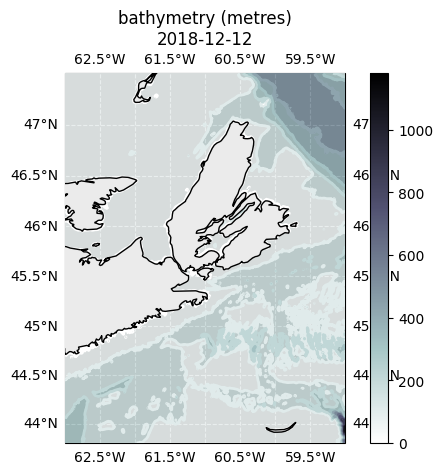

In [20]:
plot2D(var='bathymetry', source='gebco', **kwargs)
#plot2D(var='salinity', source='hycom', **kwargs)
#plot_util.plot2D(var='salinity', source='hycom', **kwargs)
#        south=43, west=-63, 
#        north=58, east=-59

In [141]:
# figure boundaries to pass as arguments to the plot function
#kwargs = dict(
#        south=44, west=-63, 
#        north=48, east=-59
#)

# ocean boundaries
bounds = dict(
               south=43.53, north=44.29, west=-59.84, east=-58.48,
               start=datetime(2018,12,12), end=datetime(2018,12,13), 
               top=0, bottom=10000
             )

In [142]:
# data sources
data_sources = dict(load_bathymetry='gebco', 
                    load_temperature='hycom', 
                    load_salinity='hycom') 
                    #load_wind_uv='wwiii', 
                    #load_wind_uv='era5',
                    #load_waveheight='wwiii')
                    #load_waveheight='era5')
# initialize Ocean instance
gully = kadlu.Ocean(**bounds, **data_sources)

Initializing Ocean in region 43.53°N,44.29°N;59.84°W58.48°W,10000m,0m for time period 2018-12-12 00:00:00 to 2018-12-13 00:00:00 with variables: ['bathymetry', 'temperature', 'salinity']
Finished loading bathymetry
  value: shape=(59841,) min=-10.000 max=3263.000 avg=582.418
    lat: shape=(59841,) min=43.531 max=44.290 avg=43.910
    lon: shape=(59841,) min=-59.840 max=-58.481 avg=-59.160
[HYCOM] Fetching salinity in region 43.53°N,44.29°N;59.84°W58.48°W,10000m,0m for time period 2018-12-12 00:00:00 to 2018-12-13 00:00:00
Finished loading salinity
  value: shape=(64692,) min=31.155 max=35.189 avg=32.513
    lat: shape=(64692,) min=43.560 max=44.280 avg=43.880
    lon: shape=(64692,) min=-59.760 max=-58.560 avg=-59.099
  epoch: shape=(64692,) min=166080.000 max=166104.000 avg=166092.000
  depth: shape=(64692,) min=0.000 max=2500.000 avg=129.995
The data points only cover 45.8% of the full rectangular box
Interpolating 273600 data points on 4D irregular grid using method `nearest` and b

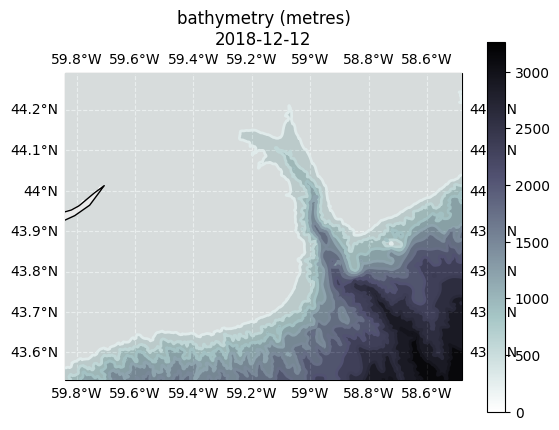

In [143]:
#plot2D(var='bathymetry', source='gebco', **kwargs)

#plot2D(var='bathymetry', source='gebco', **bounds)

plot2D(var='bathymetry', source='gebco', **bounds)

In [144]:
# data sources
data_sources = dict(load_bathymetry='gebco',  
                    load_wind_uv='era5',
                    load_waveheight='era5',
                    load_wavedirection='era5')
# initialize Ocean instance
gullywind = kadlu.Ocean(**bounds, **data_sources)

Initializing Ocean in region 43.53°N,44.29°N;59.84°W58.48°W,10000m,0m for time period 2018-12-12 00:00:00 to 2018-12-13 00:00:00 with variables: ['bathymetry', 'wind_uv', 'waveheight', 'wavedirection']
Finished loading bathymetry
  value: shape=(59841,) min=-10.000 max=3263.000 avg=582.418
    lat: shape=(59841,) min=43.531 max=44.290 avg=43.910
    lon: shape=(59841,) min=-59.840 max=-58.481 avg=-59.160
Finished loading wavedirection
  value: shape=(432,) min=41.487 max=212.852 avg=136.347
    lat: shape=(432,) min=43.750 max=44.250 avg=44.000
    lon: shape=(432,) min=-59.750 max=-58.500 avg=-59.125
  epoch: shape=(432,) min=166080.000 max=166103.000 avg=166091.500
Finished loading waveheight
  value: shape=(432,) min=1.569 max=2.922 avg=2.119
    lat: shape=(432,) min=43.750 max=44.250 avg=44.000
    lon: shape=(432,) min=-59.750 max=-58.500 avg=-59.125
  epoch: shape=(432,) min=166080.000 max=166103.000 avg=166091.500
Finished loading wind_uv
  value: shape=(432,) min=1.717 max=11.

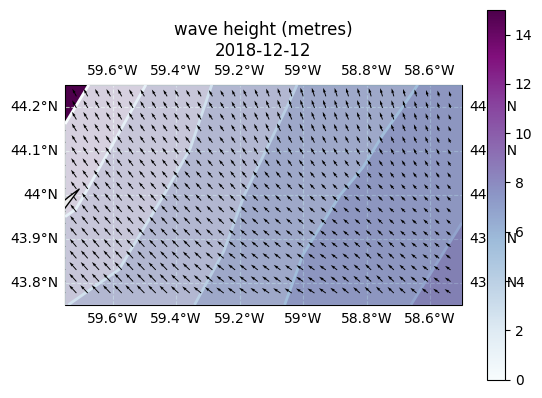

In [145]:
plot2D(var='waveheight', source='era5', plot_wind='era5', **bounds)

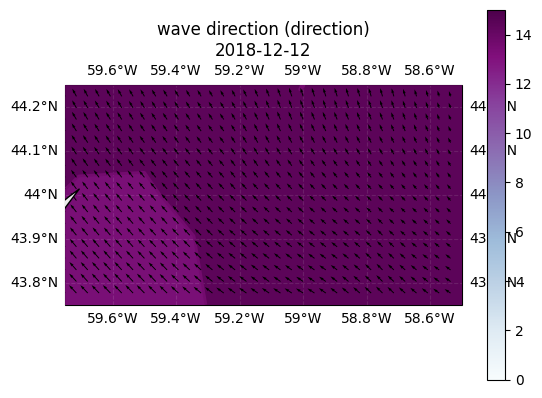

In [146]:
plot2D(var='wavedirection', source='era5', plot_wind='era5', **bounds)

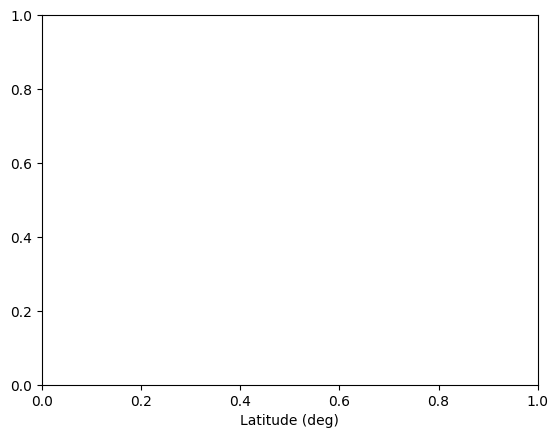

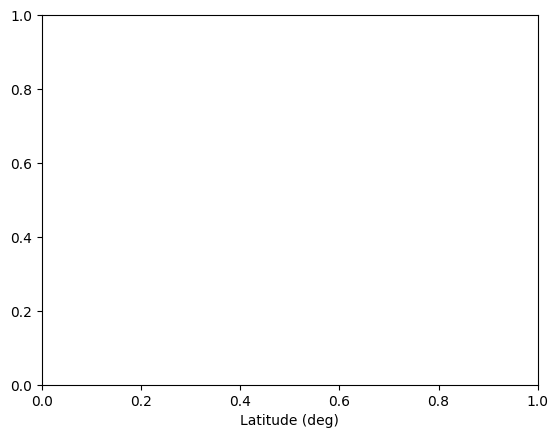

In [158]:
x = np.linspace(-58.48, -59.84, 100)
y = np.linspace(43.53, 44.29, 100)
ws = gullywind.wind_uv(lon=x,lat=y,epoch=1,grid=True)
wh = gullywind.waveheight(lon=x,lat=y,epoch=1,grid=True)
x, y = np.meshgrid(x, y)
# plot windspeed
#plt.contourf(x,y,ws)

plt.xlabel('Longitude (deg)')
plt.xlabel('Latitude (deg)')
#plt.colorbar(format='%2.0f m/s')
plt.show()
# plot waveheight
#plt.contourf(x,y,wh)
plt.xlabel('Longitude (deg)')
plt.xlabel('Latitude (deg)')
#plt.colorbar(format='%2.0f m')
plt.show()

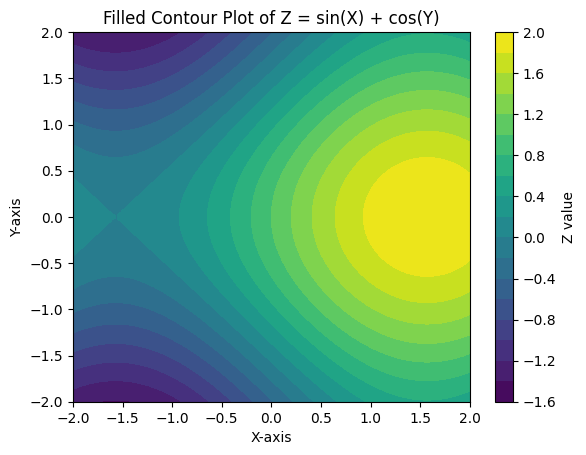

In [155]:
# Create 1D arrays for x and y
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)

# Create 2D meshgrids for X and Y
X, Y = np.meshgrid(x, y)

# Define a 2D function for Z
Z = np.sin(X) + np.cos(Y)

# Create the filled contour plot
plt.contourf(X, Y, Z, levels=20, cmap='viridis') # 20 levels, 'viridis' colormap
plt.colorbar(label='Z value') # Add a color bar
plt.title('Filled Contour Plot of Z = sin(X) + cos(Y)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [167]:
len(lat)

3456000

In [168]:
len(lon)

3456000

In [171]:
#bathy2, lat2, lon2 = kadlu.load(
#        var='bathymetry', source='gebco',
#        south=43, west=-63, 
#        north=48, east=-59
#    )
#fig = plt.scatter(lon, lat, c=bathy, cmap=plt.cm.ocean_r)

In [179]:
# ocean boundaries
bounds2 = dict(
               south=43, north=48, west=-63, east=-59,
               start=datetime(2018,12,12), end=datetime(2018,12,13), 
               top=0, bottom=1000
             )

In [180]:
# data sources
data_sources2 = dict(load_bathymetry='gebco')
# initialize Ocean instance
windarea = kadlu.Ocean(**bounds2, **data_sources2)

Initializing Ocean in region 43.00°N,48.00°N;63.00°W59.00°W,1000m,0m for time period 2018-12-12 00:00:00 to 2018-12-13 00:00:00 with variables: ['bathymetry']
Finished loading bathymetry
  value: shape=(1152000,) min=-627.000 max=3844.000 avg=181.023
    lat: shape=(1152000,) min=43.002 max=47.998 avg=45.500
    lon: shape=(1152000,) min=-62.998 max=-59.002 avg=-61.000


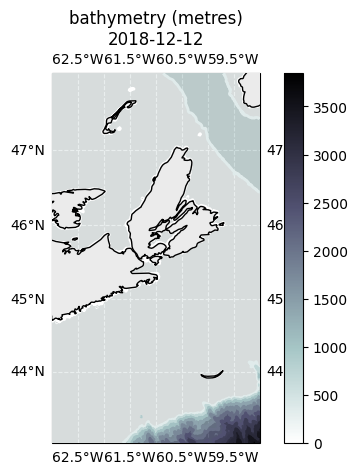

In [181]:
plot2D(var='bathymetry', source='gebco', **bounds2)